# 🎨 Supervised Classification

In this tutorial, it is required to identify between different arabic numbers. This can be used to make an optical character recognition system that can be used in many applications such as digitizing government forms, license plate recognition and more. <br><br>

Note: this tutorial has been modified from the version taught on campus to allow sharing.

In [101]:
import cv2
import numpy as np
import glob

Note of Caution: Ideally, your code should not define functions in notebooks (but rather in .py files) and should have type hints. This notebook was built for academic purposes.

## 🍳 Data Preparation

#### Prepare `x_data` and `y_data` for our model

In [102]:
# get all folder names inside Letters:
numbers = glob.glob('Dataset/*')
numbers = [folder_name.split('/')[1] for folder_name in numbers]
print(numbers)

['9', '0', '7', '6', '1', '8', '4', '3', '2', '5']


In [103]:
## 1. Fill x_data and y_data:
x_data = []
y_data = []

for number in numbers:
    for filename in sorted(glob.glob(f'Dataset/{number}/*.jpg')):
        img = cv2.imread(filename, cv2.COLOR_BGR2RGB)       ## cv2.imread reads images in BGR format
        x_data.append(img)                                  ## add the image to x_data
        y_data.append(numbers.index(number))                ## add the label to y_data
        
# 2. Convert them to Numpy arrays:
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)


# 3. Shuffle to avoid any bias:
p = np.random.permutation(len(x_data))
x_data = x_data[p]
y_data = y_data[p]

print("shape of x_data:", x_data.shape, "shape of y_data:", y_data.shape)

shape of x_data: (552, 20, 20, 3) shape of y_data: (552,)


#### Split into Train and Test

In [104]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=22, stratify=y_data)
print("shape of x_train:", x_train.shape, "shape of y_train:", y_train.shape)
print("shape of x_val:", x_val.shape, "shape of y_test:", y_val.shape)

shape of x_train: (441, 20, 20, 3) shape of y_train: (441,)
shape of x_val: (111, 20, 20, 3) shape of y_test: (111,)


#### Plot the Dataset

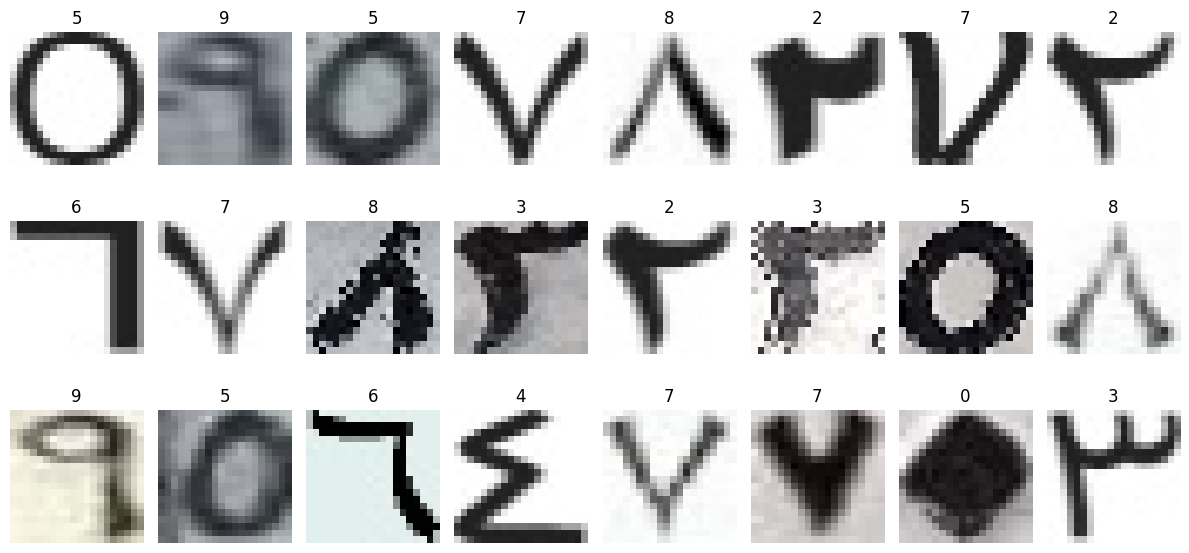

In [105]:
import numpy as np
import math
import matplotlib.pyplot as plt

def plot_dataset(x_data, y_data, num_rows=3, num_cols=8, cmap=None):
    # Create a figure and axis objects
    num_images = len(y_data)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    # Flatten the axes array to loop over them easily
    axes = axes.flatten()

    # Loop through the images and plot them
    for i in range(num_cols*num_rows):
        axes[i].imshow(x_data[i], cmap=cmap)
        axes[i].axis('off')
        axes[i].set_title('x_data Image')
        label = numbers[y_data[i]]
        axes[i].set_title('{}'.format(label))
        
    # remove extra plots
    for j in range(num_images, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

plot_dataset(x_train, y_train, num_cols=8, cmap='gray')

## 2) Data Preprocessing

There a few things to consider before we extract any features:
1. It's pointless to have three channels as each image is black and white
2. There may be noise in some of the images and blurring should help for that
3. It's pointless to have 255 colors for each pixels (0 or 255 is enough)

In [119]:
import cv2
import numpy as np

def preprocess_img(img):
    # convert to gray
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # apply gaussian blur
    filtered_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    
    # Pixels < 90 will be considered 0, and 255 otherwise. Use Otsu thresholding
    _, thresholded_img = cv2.threshold(filtered_img, 90, 255,  cv2.THRESH_OTSU)
    return thresholded_img

x_train_p = np.array([preprocess_img(img) for img in x_train])
x_val_p = np.array([preprocess_img(img) for img in x_val])

print("Shape of x_train:", x_train_p.shape)
print("Shape of x_val:", x_val_p.shape)

Shape of x_train: (441, 20, 20)
Shape of x_val: (111, 20, 20)


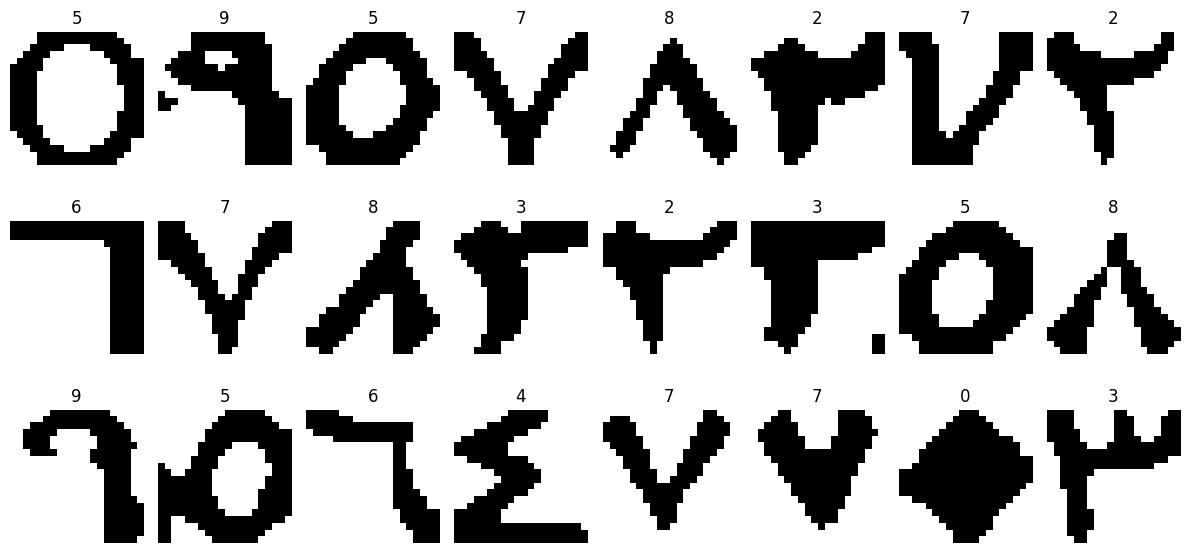

In [120]:
plot_dataset(x_train_p, y_train, num_cols=8, cmap='gray')

## 3) Feature Extraction

**This step could be either:**
    
- **Feature Engineering:** transformation of raw data into features suitable for modeling. (using domain knowledge to extract features)

- **Feature Transformation:** (transforming the whole feature space into a more meaningful one like in PCA or just applying a function on data concerning a certain feature)

- **Feature Selection:** removing unnecessary features.

Let's consider the naive approach of summing the pixels horizontally and vertically then concatenating both results:

In [121]:
import numpy as np

def extract_features(images):
    num_samples, height, width = images.shape
    # Initialize an empty array to hold the features
    features = np.zeros((num_samples, height + width))
    
    for i in range(num_samples):
        image = images[i]
        # Sum pixels horizontally (sum along columns, axis 1)
        horizontal_sum = np.sum(image, axis=1)
        # Sum pixels vertically (sum along rows, axis 0)
        vertical_sum = np.sum(image, axis=0)
        # Concatenate horizontal and vertical sums
        features[i] = np.concatenate((horizontal_sum, vertical_sum))
    
    return features

x_train_pf = extract_features(x_train_p)
x_val_pf = extract_features(x_val_p)
print(x_train_pf.shape)

(441, 40)


## 4) Model Selection

Let's start by trying [NearestCentroid](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html)

In [122]:
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score

# initiate and train the model
mdc = NearestCentroid(metric='euclidean')
mdc.fit(x_train_pf, y_train)

# predict on the validation set
y_pred = mdc.predict(x_val_pf)

# calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", round(accuracy, 4), "with NearestCentroid")

Accuracy: 0.8378 with NearestCentroid


In [123]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# initiate and train the model
knn = KNeighborsClassifier(n_neighbors=4, metric='euclidean') 
knn.fit(x_train_pf, y_train)

# predict on the validation set
y_pred = knn.predict(x_val_pf)

# calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", round(accuracy, 4), "with KNeighborsClassifier")

Accuracy: 0.9099 with KNeighborsClassifier


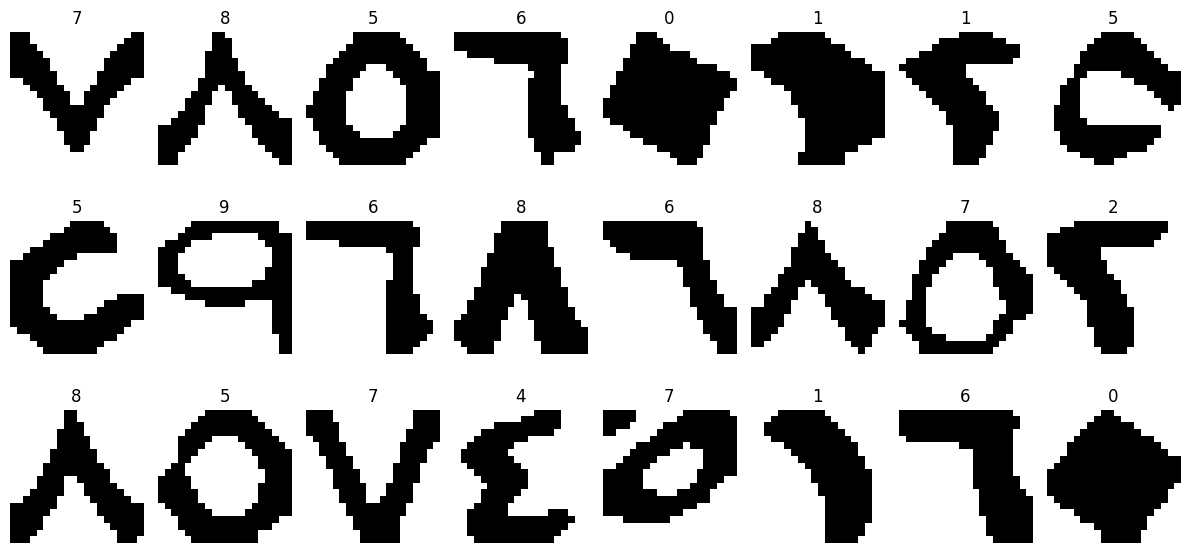

In [124]:
plot_dataset(x_val_p, y_pred, num_cols=8, cmap='gray')

## 5) Save and Deploy

Let's go for the minimum distance classifier because it's more efficient.

In [125]:
from joblib import dump, load
# save locally
dump(mdc, 'mdc.joblib') 

['mdc.joblib']

Load and run

In [126]:
mdc = load('mdc.joblib')
mdc.predict(x_val_pf[:10])

array([2, 5, 9, 3, 1, 4, 4, 5, 9, 2])

Check more classification and regression models [here](https://scikit-learn.org/stable/supervised_learning.html).